이 데이터를 활용하여 조사 기간 동안 서울의 평균기온이 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA를 사용하여 분석하고 향후 1년 동안의 기간을 만나보고 있습니다.

의무 기간은 2023년 8월 6일 기준을 대략 1년으로 한다.

In [1]:
import sys
sys.path.append("../../")

import pyupbit
import datetime as dt
from matplotlib import pyplot as plt
from datetime import timedelta
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb
from pandas import read_excel
from helper import set_datetime_index, exp_time_data

In [2]:
df = read_excel('https://data.hossam.kr/E06/temperatures_seoul.xlsx')
df

,날짜,평균기온(℃)
0,1973-07-01,22.7
1,1973-07-02,23.8
2,1973-07-03,27.2
3,1973-07-04,25.2
4,1973-07-05,26.9
...,...,...
18294,2023-08-02,29.7
18295,2023-08-03,29.5
18296,2023-08-04,30.0
18297,2023-08-05,30.3


In [3]:
df.columns = ['date', 'C.']
df

,date,C.
0,1973-07-01,22.7
1,1973-07-02,23.8
2,1973-07-03,27.2
3,1973-07-04,25.2
4,1973-07-05,26.9
...,...,...
18294,2023-08-02,29.7
18295,2023-08-03,29.5
18296,2023-08-04,30.0
18297,2023-08-05,30.3


In [4]:
df.dtypes

date    datetime64[ns]
C.             float64
dtype: object

In [5]:
df.isna().sum()

date    0
C.      0
dtype: int64

In [6]:
df3 = set_datetime_index(df, 'date')
df3.head()

,C.
1973-07-01,22.7
1973-07-02,23.8
1973-07-03,27.2
1973-07-04,25.2
1973-07-05,26.9


결측치 수: 0


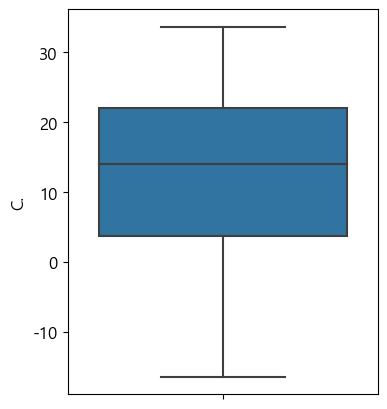

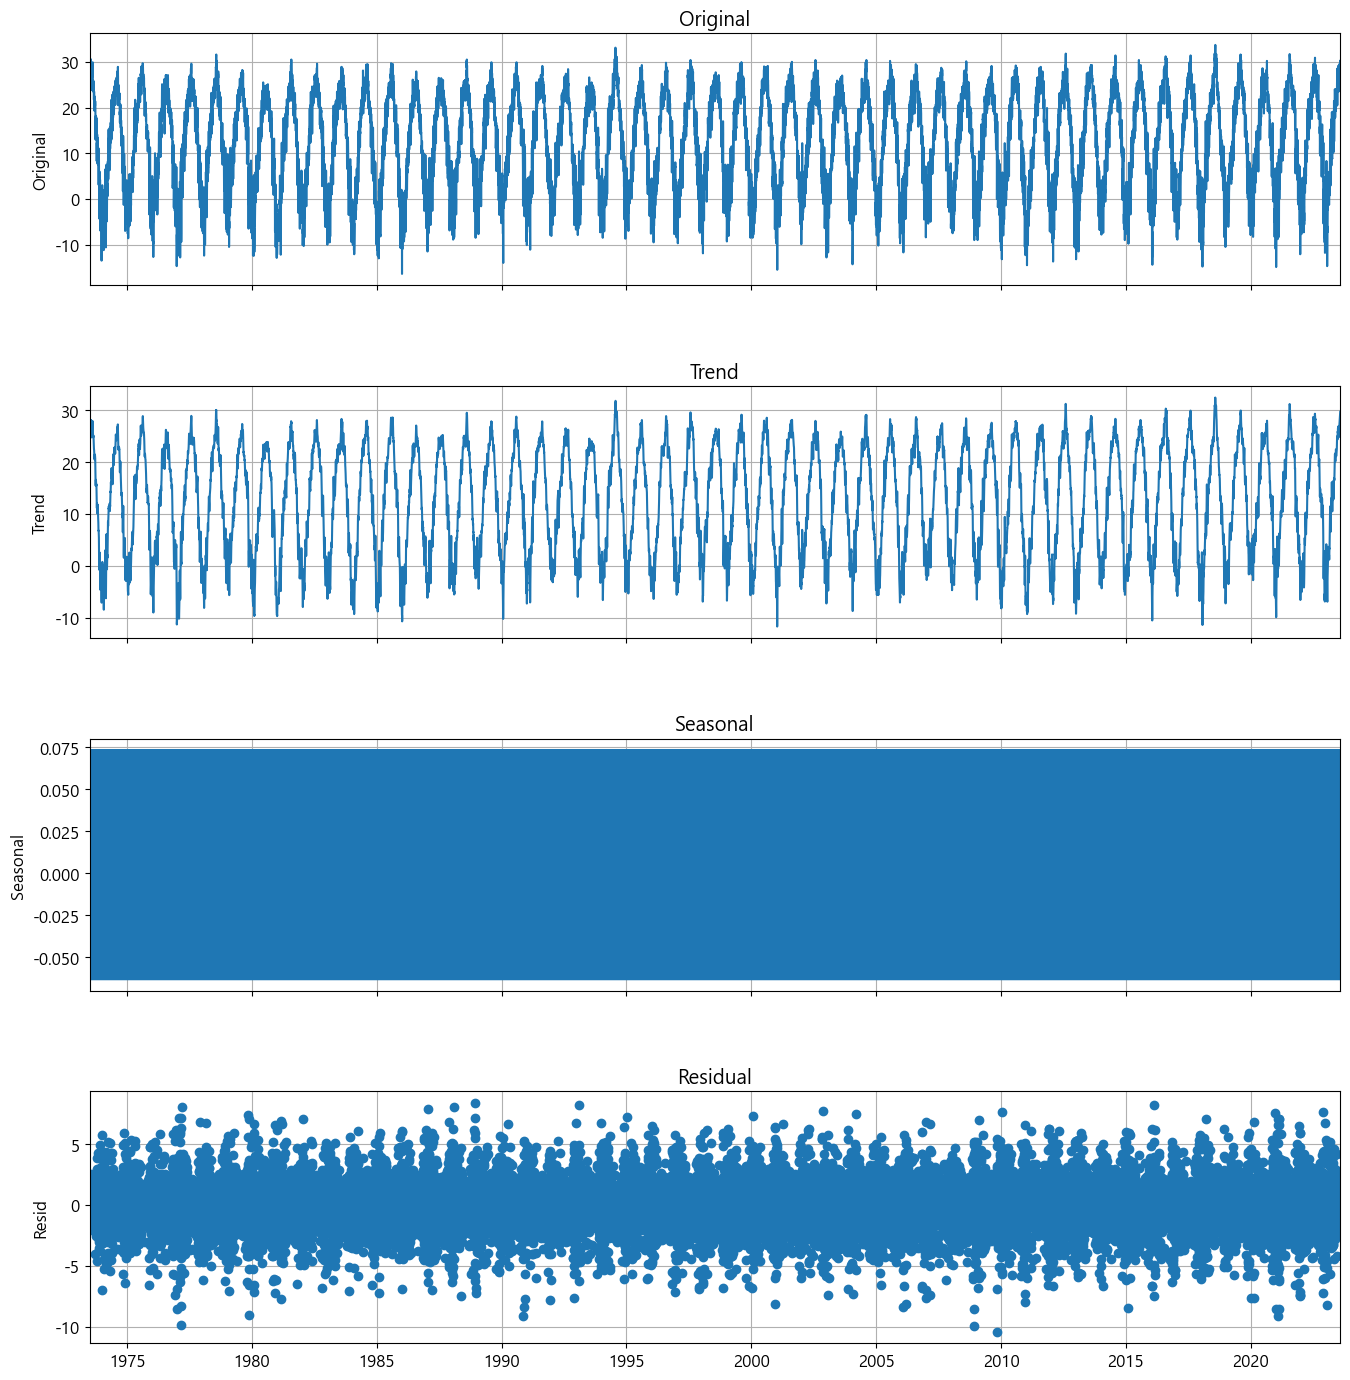

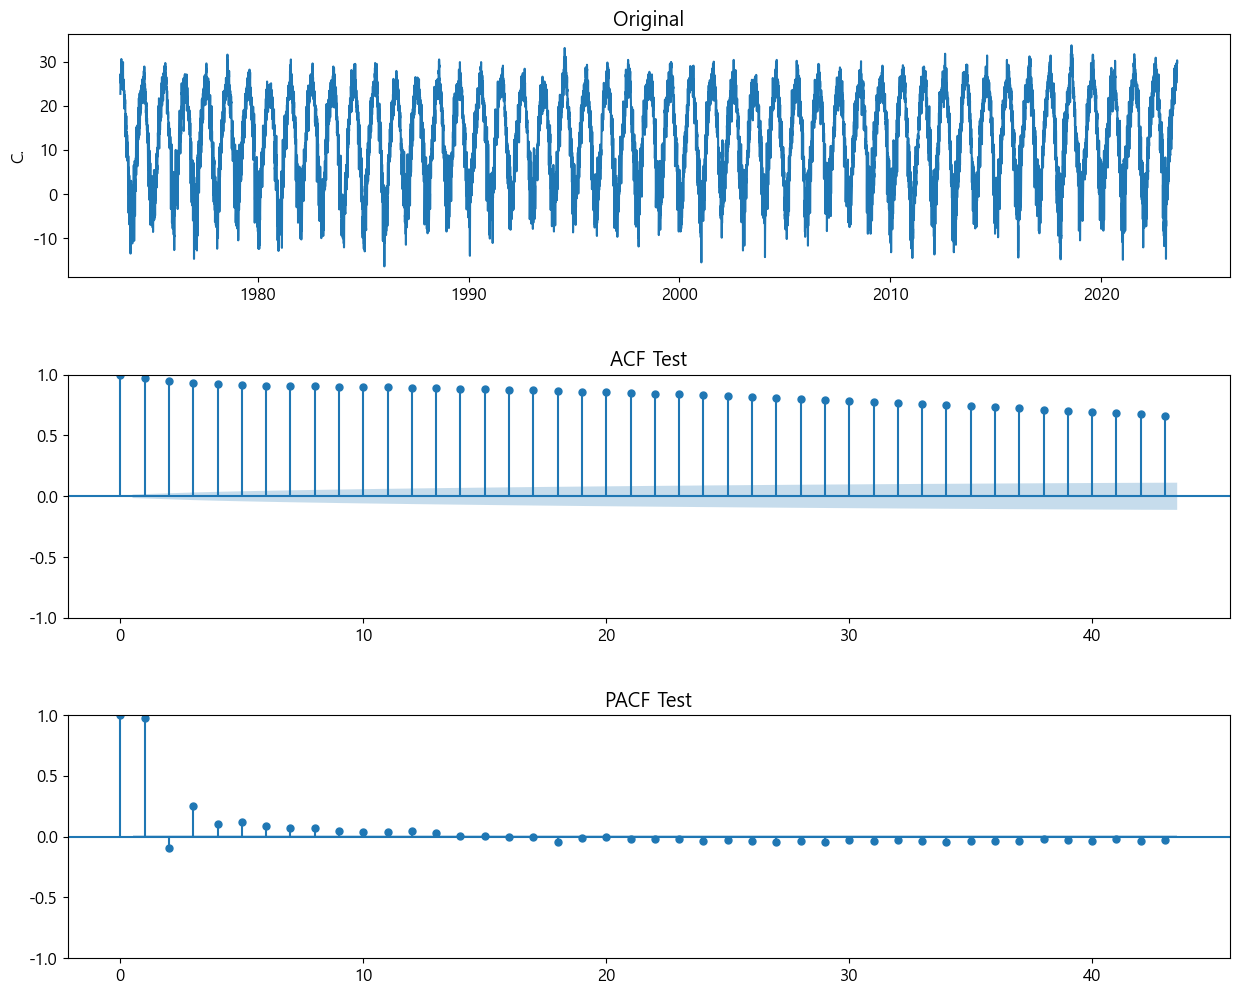

=========== 원본 데이터 ===========
+------------------------------------+-------------+
| ADF Test                           |             |
|------------------------------------+-------------|
| 검정통계량(ADF Statistic)          |    -13.6504 |
| 유의수준(p-value)                  | 1.58975e-25 |
| 최적차수(num of lags)              |          45 |
| 관측치 개수(num of observations)   |       18253 |
| 기각값(Critical Values) 1%         |    -3.43071 |
| 기각값(Critical Values) 5%         |     -2.8617 |
| 기각값(Critical Values) 10%        |    -2.56685 |
| 데이터 정상성 여부(0=Flase,1=True) |           1 |
+------------------------------------+-------------+


In [7]:
exp_time_data(data=df3, yname="C.", sd_model="a")

In [8]:
model = ARIMA(df3['C.'], order=(1,0,0), seasonal_order=(1,1,0,7))
fit = model.fit()
print(fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                              C.   No. Observations:                18299
Model:             ARIMA(1, 0, 0)x(1, 1, 0, 7)   Log Likelihood              -44036.794
Date:                         Tue, 08 Aug 2023   AIC                          88079.587
Time:                                 14:23:20   BIC                          88103.030
Sample:                             07-01-1973   HQIC                         88087.290
                                  - 08-06-2023                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7626      0.004    180.710      0.000       0.754       0.771
ar.S.L7       -0.5005      0.005    -93.756      0.000     

In [9]:
fv = fit.fittedvalues
fv.head()

1973-07-01    0.000000
1973-07-02    0.000323
1973-07-03    0.000559
1973-07-04    0.000751
1973-07-05    0.000818
Freq: D, dtype: float64

In [10]:
fc = fit.forecast(120)
fc.head()

2023-08-07    29.935934
2023-08-08    30.478573
2023-08-09    29.891758
2023-08-10    29.897300
2023-08-11    30.472643
Freq: D, Name: predicted_mean, dtype: float64

In [11]:
last = df3.index.max()
xmin = last-timedelta(days=200)
xmax = last+timedelta(days=180+10)
ymax = df3['C.'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2023-01-18 00:00:00'), Timestamp('2024-02-12 00:00:00'), 30.3)

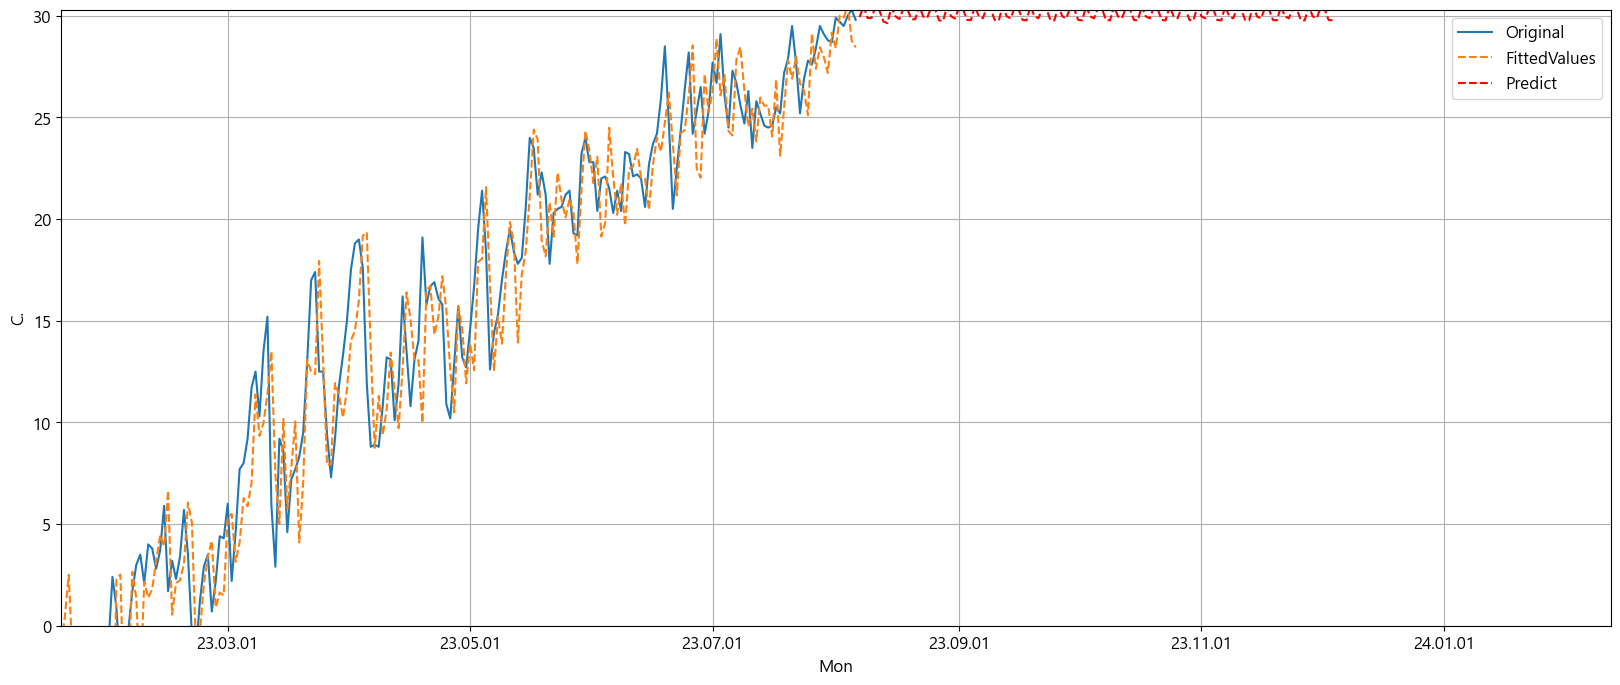

In [12]:
plt.figure(figsize=(20,8))


sb.lineplot(data=df3, x=df3.index, y='C.', label='Original')

sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')


sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Mon')
plt.ylabel('C.')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax])

monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

In [13]:
my_p = 1    # AR의 차수 (검증한 결과를 활용)
my_d = 0    # 차분 횟수 (검증한 결과를 활용)
my_q = 0    # MA의 차수 (검증한 결과를 활용)
my_s = 7    # 계절성 주기 (분석가가 판단)

model = auto_arima(
    y=df3['C.'],  # 모델링하려는 시계열 데이터 또는 배열
    start_p=0,           # p의 시작점
    max_p=my_p,          # p의 최대값
    d=my_d,              # 차분 횟수
    start_q=0,           # q의 시작점
    max_q=my_q,          # q의 최대값
    seasonal=True,       # 계절성 사용 여부
    m=my_s,              # 계절성 주기
    start_P=0,           # P의 시작점
    max_P=my_p,          # P의 최대값
    D=my_d,              # 계절성 차분 횟수
    start_Q=0,           # Q의 시작점
    max_Q=my_q,          # Q의 최대값
    trace=True           # 학습 과정 표시 여부
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=137777.710, Time=0.21 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=82947.239, Time=5.78 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=154307.360, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=82945.247, Time=0.48 sec
 ARIMA(1,0,0)(0,0,0)[7]             : AIC=83083.833, Time=0.22 sec

Best model:  ARIMA(1,0,0)(0,0,0)[7] intercept
Total fit time: 6.803 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                18299
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -41469.624
Date:                Tue, 08 Aug 2023   AIC                          82945.247
Time:                        14:23:29   BIC                          82968.691
Sample:                    07-01-1973   HQIC                         82952.950
                         - 08-06-2023                                

In [14]:
fv = model.fittedvalues()
fv.head()

1973-07-01    12.705075
1973-07-02    22.447670
1973-07-03    23.519900
1973-07-04    26.834064
1973-07-05    24.884556
Freq: D, dtype: float64

In [15]:
fc = model.predict(n_periods=180)
fc.head()

2023-08-07    29.368425
2023-08-08    28.947746
2023-08-09    28.537687
2023-08-10    28.137981
2023-08-11    27.748365
Freq: D, dtype: float64

In [16]:
last = df3.index.max()
xmin = last-timedelta(days=180)
xmax = last+timedelta(days=180+10)
ymax = df3['C.'][xmin:xmax].max()
xmin, xmax, ymax

(Timestamp('2023-02-07 00:00:00'), Timestamp('2024-02-12 00:00:00'), 30.3)

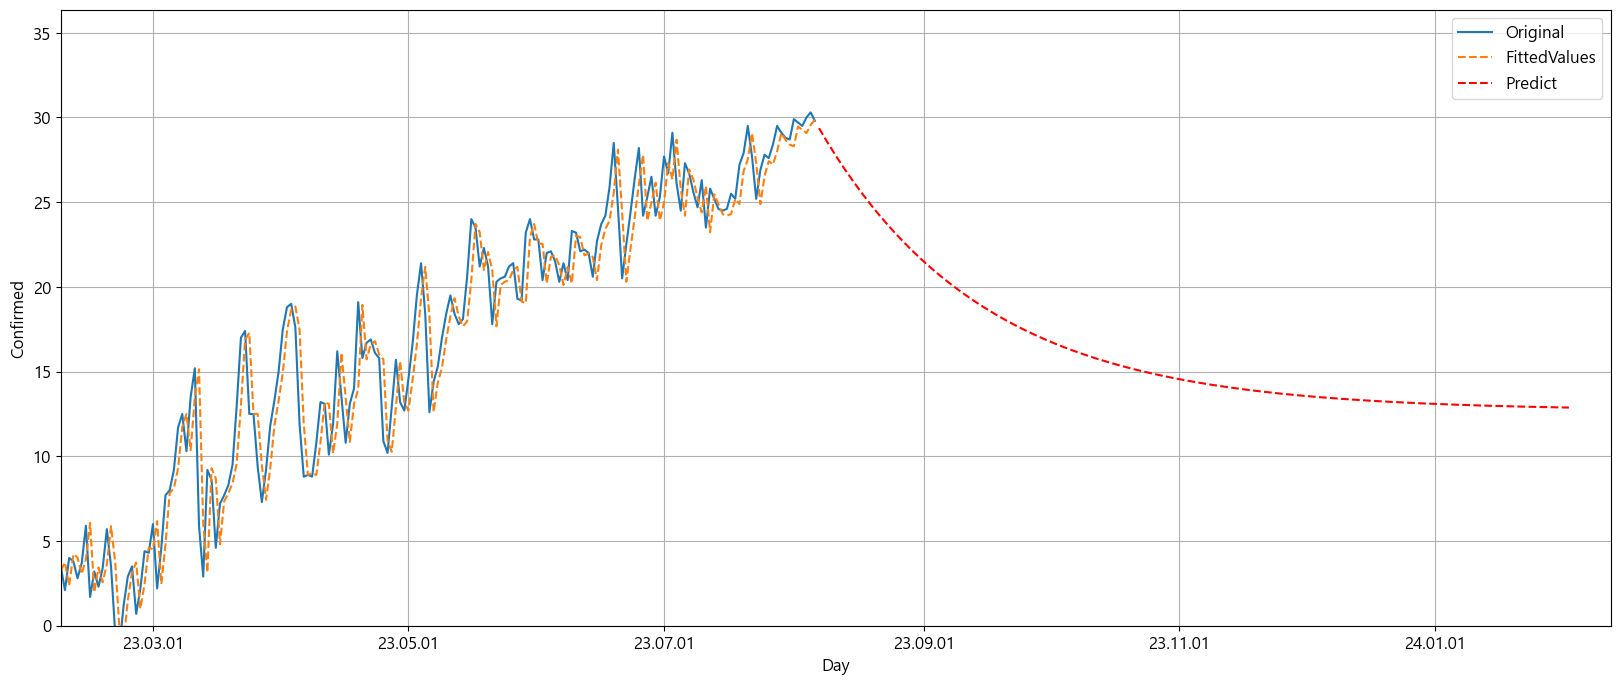

In [17]:
plt.figure(figsize=(20,8))

# 원본 데이터
sb.lineplot(data=df3, x=df3.index, y='C.', label='Original')

# 원본에 대한 학습결과
sb.lineplot(x=fv.index, y=fv.values, label='FittedValues', linestyle='--')

# 향후 120일간의 예측값
sb.lineplot(x=fc.index, y=fc.values, label='Predict', linestyle='--', color='red')

plt.xlabel('Day')
plt.ylabel('Confirmed')
plt.legend()

plt.xlim([xmin, xmax])
plt.ylim([0, ymax*1.2])

# 그래프의 x축이 날짜로 구성되어 있을 경우 형식 지정
monthyearFmt = mdates.DateFormatter('%y.%m.%d')
plt.gca().xaxis.set_major_formatter(monthyearFmt)

plt.grid()
plt.show()
plt.close()

문제 2

 이 데이터를 활용하여 조사 기간 동안 신생아 신생아 수가 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA중 가장 최근에 사용 가능한 방식을 선택하여 예측하고 향후 5년의 시간을 예측할 수 있는 자료를 찾게 오겠습니다.

 단, 조사하지 않은 항목에 지방이 신생아 수인 0것으로 간주한다.

In [18]:
df = read_excel('https://data.hossam.kr/E06/newborn.xlsx')
df

,시점,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
0,1981년 01월,21461,7846,3547,2886,NaN,NaN,NaN,NaN,9685,3729,3002,6293,4956,8741,7454,7501,1050
1,1981년 02월,23389,8622,3588,3044,NaN,NaN,NaN,NaN,10352,3637,3161,7761,5326,8319,7446,8039,872
2,1981년 03월,15042,6284,2885,2456,NaN,NaN,NaN,NaN,7727,3158,2486,5214,3855,7566,6229,6714,805
3,1981년 04월,15231,5806,2783,2369,NaN,NaN,NaN,NaN,7321,3166,2230,4621,3634,6553,5548,6079,752
4,1981년 05월,16239,6225,2808,2468,NaN,NaN,NaN,NaN,7823,3234,2419,4879,3709,6564,5529,6222,821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2023년 01월,4079,1303,905,1428,626.0,675.0,519.0,313.0,6957,675,698,921,687,780,1041,1230,345
505,2023년 02월,3284,1130,801,1187,588.0,650.0,436.0,278.0,5979,602,636,805,539,671,942,1139,272
506,2023년 03월,3605,1170,905,1219,572.0,658.0,489.0,255.0,6306,640,725,826,589,714,923,1256,286
507,2023년 04월,3062,1059,719,1061,490.0,599.0,418.0,236.0,5657,545,638,763,518,622,825,1007,266


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 509 entries, 0 to 508
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   시점       509 non-null    object 
 1   서울특별시    509 non-null    int64  
 2   부산광역시    509 non-null    int64  
 3   대구광역시    509 non-null    int64  
 4   인천광역시    509 non-null    int64  
 5   광주광역시    449 non-null    float64
 6   대전광역시    413 non-null    float64
 7   울산광역시    317 non-null    float64
 8   세종특별자치시  137 non-null    float64
 9   경기도      509 non-null    int64  
 10  강원도      509 non-null    int64  
 11  충청북도     509 non-null    int64  
 12  충청남도     509 non-null    int64  
 13  전라북도     509 non-null    int64  
 14  전라남도     509 non-null    int64  
 15  경상북도     509 non-null    int64  
 16  경상남도     509 non-null    int64  
 17  제주특별자치도  509 non-null    int64  
dtypes: float64(4), int64(13), object(1)
memory usage: 71.7+ KB


In [20]:
df.describe()

,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
count,509.000000,509.000000,509.000000,509.000000,449.000000,413.000000,317.000000,137.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000,509.000000
mean,10060.180747,3296.933202,2158.231827,2359.634578,1260.527840,1260.617433,935.000000,234.153285,9362.078585,1415.516699,1395.255403,2063.754420,1775.019646,2195.176817,2603.774067,3559.229862,551.823183
std,4144.265364,1526.728812,741.764504,656.063316,412.710325,361.697252,269.715239,89.037987,1887.471161,648.899634,461.914811,1118.030209,853.832140,1574.769551,1172.473186,1596.590521,143.373995
min,2865.000000,888.000000,663.000000,959.000000,474.000000,509.000000,334.000000,67.000000,5030.000000,482.000000,495.000000,717.000000,481.000000,501.000000,767.000000,975.000000,215.000000
25%,7176.000000,2136.000000,1628.000000,1972.000000,984.000000,1077.000000,817.000000,131.000000,7657.000000,954.000000,1108.000000,1500.000000,1223.000000,1270.000000,1823.000000,2435.000000,454.000000
50%,9215.000000,2743.000000,2101.000000,2222.000000,1191.000000,1241.000000,939.000000,265.000000,9458.000000,1305.000000,1321.000000,1716.000000,1668.000000,1730.000000,2319.000000,3013.000000,529.000000
75%,13180.000000,4461.000000,2772.000000,2832.000000,1582.000000,1537.000000,1047.000000,302.000000,10795.000000,1670.000000,1643.000000,2082.000000,2137.000000,2358.000000,3175.000000,4877.000000,669.000000
max,23389.000000,8622.000000,3879.000000,4152.000000,2402.000000,2115.000000,1771.000000,392.000000,14032.000000,4039.000000,3406.000000,7761.000000,5926.000000,9346.000000,7454.000000,8128.000000,1050.000000


In [21]:
df.fillna(0)

,시점,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
0,1981년 01월,21461,7846,3547,2886,0.0,0.0,0.0,0.0,9685,3729,3002,6293,4956,8741,7454,7501,1050
1,1981년 02월,23389,8622,3588,3044,0.0,0.0,0.0,0.0,10352,3637,3161,7761,5326,8319,7446,8039,872
2,1981년 03월,15042,6284,2885,2456,0.0,0.0,0.0,0.0,7727,3158,2486,5214,3855,7566,6229,6714,805
3,1981년 04월,15231,5806,2783,2369,0.0,0.0,0.0,0.0,7321,3166,2230,4621,3634,6553,5548,6079,752
4,1981년 05월,16239,6225,2808,2468,0.0,0.0,0.0,0.0,7823,3234,2419,4879,3709,6564,5529,6222,821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504,2023년 01월,4079,1303,905,1428,626.0,675.0,519.0,313.0,6957,675,698,921,687,780,1041,1230,345
505,2023년 02월,3284,1130,801,1187,588.0,650.0,436.0,278.0,5979,602,636,805,539,671,942,1139,272
506,2023년 03월,3605,1170,905,1219,572.0,658.0,489.0,255.0,6306,640,725,826,589,714,923,1256,286
507,2023년 04월,3062,1059,719,1061,490.0,599.0,418.0,236.0,5657,545,638,763,518,622,825,1007,266


In [1]:
import numpy as np

In [2]:
# 리스트를 통한 1차원(1행으로 구성) 배열만들기
arr = np.array([1,3,5,7,9])
arr

array([1, 3, 5, 7, 9])

In [3]:
size = len(arr)
print("배열의 원소는 %d개 입니다." % size)

배열의 원소는 5개 입니다.


In [6]:
phone_number = "01033334444"
result = "*******4444"
a = phone_number[-4:]
b = phone_number[:-4].replace("")


44440103333


In [10]:
answer = []
for i in arr:
    if len(arr) > 1:
        answer.append(i - min(arr))
    else:
        answer.append(i)
print(answer)

[0, 2, 4, 6, 8]
